# Decision Tree Ensemble Starter Kit for Kaggle House Prices 

## Imports and inits

In [4]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import xgboost as xgb
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_102"; OpenJDK Runtime Environment (Zulu 8.17.0.3-macosx) (build 1.8.0_102-b14); OpenJDK 64-Bit Server VM (Zulu 8.17.0.3-macosx) (build 25.102-b14, mixed mode)
  Starting server from /Users/yy/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/_6/rl8w_p251xxct6hj32x01drc0000gn/T/tmpiq9ak_7f
  JVM stdout: /var/folders/_6/rl8w_p251xxct6hj32x01drc0000gn/T/tmpiq9ak_7f/h2o_yy_started_from_python.out
  JVM stderr: /var/folders/_6/rl8w_p251xxct6hj32x01drc0000gn/T/tmpiq9ak_7f/h2o_yy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ------------------------------
H2O cluster uptime:         03 secs
H2O cluster version:        3.12.0.1
H2O cluster version age:    8 days
H2O cluster name:           H2O_from_python_yy_o7eed6
H2O cluster total nodes:    1
H2O cluster free memory:    1.778 Gb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.5.2 final
--------------------------  ------------------------------

## Import data

In [6]:
train = h2o.import_file('../regression/train.csv')
test = h2o.import_file('../regression/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [7]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [8]:
original_nums, cats = get_type_lists()

Numeric = ['BsmtFinSF2', 'Fireplaces', '2ndFlrSF', 'OverallCond', 'LotArea', 'MoSold', 'WoodDeckSF', 'HalfBath', 'BsmtHalfBath', 'BedroomAbvGr', 'LowQualFinSF', 'MasVnrArea', 'ScreenPorch', 'BsmtUnfSF', 'FullBath', 'MSSubClass', '3SsnPorch', 'OpenPorchSF', 'GarageArea', 'YrSold', 'TotalBsmtSF', 'LotFrontage', 'BsmtFullBath', 'BsmtFinSF1', 'PoolArea', 'GrLivArea', 'OverallQual', 'EnclosedPorch', 'KitchenAbvGr', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt', 'GarageCars', 'MiscVal', '1stFlrSF', 'TotRmsAbvGrd']

Categorical = ['Alley', 'CentralAir', 'Condition1', 'PoolQC', 'ExterQual', 'Exterior1st', 'BsmtCond', 'MasVnrType', 'Street', 'BsmtQual', 'GarageFinish', 'Electrical', 'RoofStyle', 'KitchenQual', 'Foundation', 'SaleType', 'BsmtFinType1', 'LotShape', 'PavedDrive', 'RoofMatl', 'BsmtExposure', 'BldgType', 'Exterior2nd', 'SaleCondition', 'BsmtFinType2', 'Heating', 'LandContour', 'ExterCond', 'Fence', 'GarageCond', 'GarageQual', 'Neighborhood', 'FireplaceQu', 'HouseStyle', 'MiscFeature', 

## Split into to train and validation (before doing data prep!!!)

In [9]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [10]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [11]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [12]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Alley (1/43) ...
Encoding: CentralAir (2/43) ...
Encoding: Condition1 (3/43) ...
Encoding: PoolQC (4/43) ...
Encoding: ExterQual (5/43) ...
Encoding: Exterior1st (6/43) ...
Encoding: BsmtCond (7/43) ...
Encoding: MasVnrType (8/43) ...
Encoding: Street (9/43) ...
Encoding: BsmtQual (10/43) ...
Encoding: GarageFinish (11/43) ...
Encoding: Electrical (12/43) ...
Encoding: RoofStyle (13/43) ...
Encoding: KitchenQual (14/43) ...
Encoding: Foundation (15/43) ...
Encoding: SaleType (16/43) ...
Encoding: BsmtFinType1 (17/43) ...
Encoding: LotShape (18/43) ...
Encoding: PavedDrive (19/43) ...
Encoding: RoofMatl (20/43) ...
Encoding: BsmtExposure (21/43) ...
Encoding: BldgType (22/43) ...
Encoding: Exterior2nd (23/43) ...
Encoding: SaleCondition (24/43) ...
Encoding: BsmtFinType2 (25/43) ...
Encoding: Heating (26/43) ...
Encoding: LandContour (27/43) ...
Encoding: ExterCond (28/43) ...
Encoding: Fence (29/43) ...
Encoding: GarageCond (30/43) ...
Encoding: GarageQual (31/43) ...
Encodin

#### Redefine numerics and explore

In [13]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['BsmtFinSF2', 'Fireplaces', '2ndFlrSF', 'SaleCondition_Tencode', 'TotRmsAbvGrd', 'Neighborhood_Tencode', 'HouseStyle_Tencode', 'GrLivArea', 'PoolQC_Tencode', 'MasVnrType_Tencode', 'MoSold', 'WoodDeckSF', 'HeatingQC_Tencode', 'HalfBath', 'BsmtHalfBath', 'Fence_Tencode', 'BedroomAbvGr', 'LowQualFinSF', 'LandContour_Tencode', 'MasVnrArea', 'Condition2_Tencode', 'ScreenPorch', 'BsmtUnfSF', 'FullBath', 'MSSubClass', '3SsnPorch', 'OpenPorchSF', 'ExterCond_Tencode', 'GarageArea', 'YrSold', 'GarageQual_Tencode', 'TotalBsmtSF', 'LotShape_Tencode', 'LotConfig_Tencode', 'BldgType_Tencode', 'YearRemodAdd', 'Alley_Tencode', 'BsmtCond_Tencode', 'Electrical_Tencode', 'YearBuilt', 'CentralAir_Tencode', 'MiscFeature_Tencode', 'Exterior2nd_Tencode', 'BsmtFullBath', 'GarageFinish_Tencode', 'Exterior1st_Tencode', 'BsmtFinSF1', 'ExterQual_Tencode', 'KitchenQual_Tencode', 'PoolArea', 'Foundation_Tencode', 'GarageCond_Tencode', 'BsmtExposure_Tencode', 'LotArea', 'EnclosedPorch', 'RoofMatl_Tencode'

In [14]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




BsmtFinSF2 Fireplaces 2ndFlrSF SaleCondition_Tencode TotRmsAbvGrd Neighborhood_Tencode HouseStyle_Tencode GrLivArea PoolQC_Tencode MasVnrType_Tencode MoSold WoodDeckSF HeatingQC_Tencode HalfBath BsmtHalfBath Fence_Tencode BedroomAbvGr LowQualFinSF LandContour_Tencode MasVnrArea Condition2_Tencode ScreenPorch BsmtUnfSF FullBath MSSubClass 3SsnPorch OpenPorchSF ExterCond_Tencode GarageArea YrSold GarageQual_Tencode TotalBsmtSF LotShape_Tencode LotConfig_Tencode BldgType_Tencode YearRemodAdd Alley_Tencode BsmtCond_Tencode Electrical_Tencode YearBuilt CentralAir_Tencode MiscFeature_Tencode Exterior2nd_Tencode BsmtFullBath GarageFinish_Tencode Exterior1st_Tencode BsmtFinSF1 ExterQual_Tencode KitchenQual_Tencode PoolArea Foundation_Tencode GarageCond_Tencode BsmtExposure_Tencode LotArea EnclosedPorch RoofMatl_Tencode MSZoning_Tencode KitchenAbvGr Functional_Tencode Street_Tencode LandSlope_Tencode BsmtQual_Tencode SaleType_Tencode Heating_Tencode OverallCond Condition1_Tencode BsmtFinType2_Tencode RoofStyle_Tencode GarageCars OverallQual FireplaceQu_Tencode LotFrontage GarageType_Tencode BsmtFinType1_Tencode PavedDrive_Tencode MiscVal 1stFlrSF Utilities_Tencode GarageYrBlt 
 
 
 type int int int real int real real int real real int int real int int real int int real real real int int int int int int real int int real int real real real int real real real int real real real int real real int real real int real real real int int real real int real real real real real real int real real real int int real real real real real int int real real 
 mins 0.0 0.0 0.0 115832.04385614385 3.0 109690.79385614385 118907.22242757239 480.0 182171.95904095902 155578.6188811189 1.0 0.0 135668.69902855766 0.0 0.0 141306.73814185814 0.0 0.0 145140.16285614387 0.0 108075.79385614385 0.0 0.0 0.0 20.0 0.0 0.0 122047.14941169939 0.0 2006.0 96813.29385614385 0.0 163944.59385614382 176473.2899159664 138273.46052281052 1950.0 128075.200999001 84275.79385614385 84275.79385614385 1875.0 119608.23368665231 140375.79385614386 129978.23968947721 0.0 141354.57177033494 78325.79385614385 0.0 116078.96885614384 124936.94820396995 0.0 121726.89385614387 112070.79385614385 167645.4123076923 1300.0 0.0 143775.79385614386 78614.79385614385 0.0 110059.12718947718 146350.10385614386 181486.5182747485 121216.12093947716 125968.29385614385 93469.96052281052 2.0 134468.29385614386 154536.9355228105 161577.2224275724 0.0 2.0 141462.34885614386 21.0 125174.9605228105 150410.4464877228 129253.89464979463 0.0 480.0 144200.79385614386 1908.0 
 mean 41.64935064935066 0.6203796203796204 341.7872127872128 181541.32494458588 6.512487512487512 182171.95904095905 183188.25635258845 1519.8011988011988 182802.8256832079 180574.40004970058 6.362637362637362 91.07392607392607 182409.7085632649 0.38161838161838163 0.059940059940059943 177450.87030976015 2.871128871128871 5.9250749250749255 182186.73299732234 106.91146881287727 182224.4420403772 14.763236763236764 575.99000999001 1.5744255744255744 57.08791208791209 3.4565434565434567 44.92407592407592 182637.23505924648 477.46853146853147 2007.828171828172 186018.32971548932 1063.2387612387613 181993.9278632456 181772.16118142597 182849.79797600003 1985.138861138861 180171.38546862727 184043.11900766566 182952.64128239392 1972.2987012987012 182822.70708043207 181198.19224147478 183994.52609268852 0.42657342657342656 185712.8721618042 183565.71379414795 445.5994005994006 181095.69602749898 180810.97023994985 3.3766233766233764 183119.90242260235 186002.74671607107 182844.62529074325 10628.262737262738 21.257742257742258 182033.94005549897 183387.92640181992 1.046953046953047 182576.24533688094 182203.5349842964 182145.0556687069 182245.41278741238 181180.3311701286 182323.579859551 5.583416583416583 182645.11776425375 184056.7578759402 182159.00869385363 1.7932067932067932 6.1448551448551445 200266.80114860163 70.59975669099757 185255.62265751234 185645.79515235015 182908.18055950044 39.684315684315685 1172.0889110889111 182178.65314071544 197

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




BsmtFinSF2 Fireplaces 2ndFlrSF SaleCondition_Tencode TotRmsAbvGrd Neighborhood_Tencode HouseStyle_Tencode GrLivArea PoolQC_Tencode MasVnrType_Tencode MoSold WoodDeckSF HeatingQC_Tencode HalfBath BsmtHalfBath Fence_Tencode BedroomAbvGr LowQualFinSF LandContour_Tencode MasVnrArea Condition2_Tencode ScreenPorch BsmtUnfSF FullBath MSSubClass 3SsnPorch OpenPorchSF ExterCond_Tencode GarageArea YrSold GarageQual_Tencode TotalBsmtSF LotShape_Tencode LotConfig_Tencode BldgType_Tencode YearRemodAdd Alley_Tencode BsmtCond_Tencode Electrical_Tencode YearBuilt CentralAir_Tencode MiscFeature_Tencode Exterior2nd_Tencode BsmtFullBath GarageFinish_Tencode Exterior1st_Tencode BsmtFinSF1 ExterQual_Tencode KitchenQual_Tencode PoolArea Foundation_Tencode GarageCond_Tencode BsmtExposure_Tencode LotArea EnclosedPorch RoofMatl_Tencode MSZoning_Tencode KitchenAbvGr Functional_Tencode Street_Tencode LandSlope_Tencode BsmtQual_Tencode SaleType_Tencode Heating_Tencode OverallCond Condition1_Tencode BsmtFinType2_Tencode RoofStyle_Tencode GarageCars OverallQual FireplaceQu_Tencode LotFrontage GarageType_Tencode BsmtFinType1_Tencode PavedDrive_Tencode MiscVal 1stFlrSF Utilities_Tencode GarageYrBlt 
 
 
 type int int int real int real real int real real int int real int int real int int real real real int int int int int int real int int real int real real real int real real real int real real real int real real int real real int real real real int int real real int real real real real real real int real real real int int real real real real real int int real real 
 mins 0.0 0.0 0.0 143816.52450980392 2.0 112866.7168174962 122402.59593837534 334.0 178193.4967320261 131576.52450980392 1.0 0.0 100679.02450980392 0.0 0.0 133419.96200980392 0.0 0.0 163075.56297134238 0.0 84954.02450980392 0.0 0.0 0.0 20.0 0.0 0.0 91754.02450980392 0.0 2006.0 134853.20367647058 0.0 163981.4191419142 165751.57330498463 128987.56617647059 1950.0 134607.54723707662 78579.02450980392 100143.52450980392 1872.0 111601.52450980392 73479.02450980392 106204.02450980392 0.0 143948.79679144386 96429.02450980392 0.0 91042.14950980392 105130.89950980392 0.0 110363.31736694675 118776.94117647059 161376.63366336632 1491.0 0.0 175904.02450980392 118217.35784313723 1.0 84954.02450980392 95579.02450980392 175531.83179723503 134771.7517825312 107734.02450980392 77729.02450980392 1.0 150223.0311764706 145091.52450980392 139864.02450980392 0.0 1.0 133191.52450980392 21.0 111434.07450980392 146338.19117647054 114840.96895424835 0.0 334.0 178193.4967320261 1900.0 
 mean 57.23529411764706 0.5969498910675382 358.3442265795207 177335.48292323467 6.529411764705882 178193.49673202613 177648.76674783204 1506.004357298475 178198.69396030012 176108.20460862634 6.233115468409586 101.15904139433552 180663.6615169379 0.38562091503267976 0.05228758169934641 173941.1787702735 2.8562091503267975 5.668845315904139 177854.22806185653 96.68340611353712 178197.18104147978 15.710239651416122 548.1590413943355 1.5446623093681917 56.48148148148148 3.30718954248366 50.446623093681914 178484.55631381093 463.1917211328976 2007.7886710239652 184195.20382758768 1044.7603485838779 176786.22238241704 178163.26637404418 178649.14910504507 1984.2701525054467 176164.9969256838 180413.2355397497 179083.6277286514 1969.0196078431372 179115.18492887347 177409.66351972887 179728.60882139349 0.4226579520697168 181122.03431372548 179651.10523303002 439.36601307189545 174940.2994916485 177298.2844312017 1.411764705882353 179041.90369302404 184432.0126553889 178366.110436157 10273.808278867102 23.47276688453159 177969.71943483275 179328.32668845312 1.0457516339869284 178425.73264556366 178225.25931265755 177815.9926203597 179069.59942970652 177239.63702422145 178371.04867785895 5.557734204793029 178617.62590029472 180587.6997415524 177381.1458157119 1.710239651416122 6.0 194587.7731541999 68.85751978891822 185134.5307937118 180031.30962236744 179002.96058140032 51.78649237472766 1141.9912854030501 178193.49673202608 1977.9953051643192 
 max

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




BsmtFinSF2 Fireplaces 2ndFlrSF SaleCondition_Tencode TotRmsAbvGrd Neighborhood_Tencode HouseStyle_Tencode GrLivArea PoolQC_Tencode MasVnrType_Tencode MoSold WoodDeckSF HeatingQC_Tencode HalfBath BsmtHalfBath Fence_Tencode BedroomAbvGr LowQualFinSF LandContour_Tencode MasVnrArea Condition2_Tencode ScreenPorch BsmtUnfSF FullBath MSSubClass 3SsnPorch OpenPorchSF ExterCond_Tencode GarageArea YrSold GarageQual_Tencode TotalBsmtSF LotShape_Tencode LotConfig_Tencode BldgType_Tencode YearRemodAdd Alley_Tencode BsmtCond_Tencode Electrical_Tencode YearBuilt CentralAir_Tencode MiscFeature_Tencode Exterior2nd_Tencode BsmtFullBath GarageFinish_Tencode Exterior1st_Tencode BsmtFinSF1 ExterQual_Tencode KitchenQual_Tencode PoolArea Foundation_Tencode GarageCond_Tencode BsmtExposure_Tencode LotArea EnclosedPorch RoofMatl_Tencode MSZoning_Tencode KitchenAbvGr Functional_Tencode Street_Tencode LandSlope_Tencode BsmtQual_Tencode SaleType_Tencode Heating_Tencode OverallCond Condition1_Tencode BsmtFinType2_Tencode RoofStyle_Tencode GarageCars OverallQual FireplaceQu_Tencode LotFrontage GarageType_Tencode BsmtFinType1_Tencode PavedDrive_Tencode MiscVal 1stFlrSF Utilities_Tencode GarageYrBlt 
 
 
 type real int int real int real real int real real int int real int real real int int real real real int real int int int int real real int real real real real real int real real real int real real real real real real real real real int real real real int int real real int real real real real real real int real real real real int real real real real real int int real real 
 mins 0.0 0.0 0.0 143816.52450980392 3.0 112866.7168174962 122402.59593837534 407.0 178193.4967320261 131576.52450980392 1.0 0.0 100679.02450980392 0.0 0.0 133419.96200980392 0.0 0.0 163075.56297134238 0.0 127029.02450980392 0.0 0.0 0.0 20.0 0.0 0.0 91754.02450980392 0.0 2006.0 134853.20367647058 0.0 163981.4191419142 165751.57330498463 128987.56617647059 1950.0 134607.54723707662 78579.02450980392 100143.52450980392 1879.0 111601.52450980392 73479.02450980392 106204.02450980392 0.0 143948.79679144386 96429.02450980392 0.0 91042.14950980392 105130.89950980392 0.0 110363.31736694675 118776.94117647059 161376.63366336632 1470.0 0.0 175904.02450980392 118217.35784313723 0.0 84954.02450980392 95579.02450980392 175531.83179723503 134771.7517825312 107734.02450980392 77729.02450980392 1.0 150223.0311764706 145091.52450980392 139864.02450980392 0.0 1.0 133191.52450980392 21.0 111434.07450980392 146338.19117647054 114840.96895424835 0.0 407.0 178193.4967320261 1895.0 
 mean 52.61934156378601 0.5812200137080191 325.96778615490064 176492.09637795313 6.385195339273475 179660.9318538107 176296.0327526845 1486.0459218642907 178193.4967320261 178207.0798692451 6.104180945853324 93.17477724468814 182227.81273899964 0.3776559287183002 0.06520247083047358 174246.9783571091 2.8540095956134337 3.5435229609321452 179174.22633752596 100.70914127423823 178369.3998087346 17.064427690198766 554.2949245541838 1.570938999314599 57.37834132967786 1.794379712131597 48.3139136394791 178138.29247727423 472.7688614540466 2007.7697052775875 182567.66333366183 1046.1179698216736 176844.0836371834 178278.00897433652 178370.36965515942 1983.6627827278958 176172.85149770897 179283.61725237887 180126.1193152811 1971.357779300891 179789.60281035837 177606.2442188893 180995.23531825157 0.4344543582704186 180987.1789957136 179810.686881209 439.2037037037037 177673.68837649442 179340.3962464452 1.7443454420836186 181006.2901857593 184620.93755108098 179354.86101843632 9819.161069225496 24.24331734064428 176751.75320615337 179232.09043019172 1.0424948594928032 178383.03720943845 178065.09267032953 177395.21920765375 181062.1068968766 175933.1071534587 179140.3483394936 5.5538039753255655 179939.77372747526 180689.57815766832 177370.7037166422 1.766117969821674 6.078821110349555 194452.82035270391 68.58035714285714 186339.7089378328 182091.99147253158 177090.15440559445 58.16792323509253 1156.534612748458 178193.4967320261 1977.721

In [15]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood Neighborhood_Tencode 
 
 
 NAmes 152080 
 NAmes 152080 
 Gilbert 191808 
 Gilbert 191808 
 StoneBr 288359


{'IDOTRR': 112866.71681749621, nan: 178193.49673202613, 'NAmes': 152080.32258672698, 'Timber': 260109.74673202613, 'CollgCr': 190019.77971813726, 'Mitchel': 169316.52450980392, 'ClearCr': 207949.02450980392, 'Edwards': 126241.13989441929, 'NWAmes': 184610.14950980392, 'NoRidge': 273948.2552790347, 'BrDale': 116064.02450980392, 'Veenker': 243734.02450980392, 'Somerst': 227656.9671023965, 'StoneBr': 288359.0245098039, 'OldTown': 139863.03613771088, 'Crawfor': 216008.84593837534, 'NridgHt': 284073.1545098039, 'NPkVill': 147641.52450980392, 'Sawyer': 143162.40700980392, 'Blmngtn': 210845.6545098039, 'SawyerW': 189097.7776348039, 'BrkSide': 129965.77450980392, 'SWISU': 156269.02450980392, 'MeadowV': 113131.52450980392, 'Gilbert': 191808.0596949891}


## Create combination features

In [16]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [17]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: BsmtFinSF2 (1/79) ...
Combining: Fireplaces (2/79) ...
Combining: 2ndFlrSF (3/79) ...
Combining: SaleCondition_Tencode (4/79) ...
Combining: TotRmsAbvGrd (5/79) ...
Combining: Neighborhood_Tencode (6/79) ...
Combining: HouseStyle_Tencode (7/79) ...
Combining: GrLivArea (8/79) ...
Combining: PoolQC_Tencode (9/79) ...
Combining: MasVnrType_Tencode (10/79) ...
Combining: MoSold (11/79) ...
Combining: WoodDeckSF (12/79) ...
Combining: HeatingQC_Tencode (13/79) ...
Combining: HalfBath (14/79) ...
Combining: BsmtHalfBath (15/79) ...
Combining: Fence_Tencode (16/79) ...
Combining: BedroomAbvGr (17/79) ...
Combining: LowQualFinSF (18/79) ...
Combining: LandContour_Tencode (19/79) ...
Combining: MasVnrArea (20/79) ...
Combining: Condition2_Tencode (21/79) ...
Combining: ScreenPorch (22/79) ...
Combining: BsmtUnfSF (23/79) ...
Combining: FullBath (24/79) ...
Combining: MSSubClass (25/79) ...
Combining: 3SsnPorch (26/79) ...
Combining: OpenPorchSF (27/79) ...
Combining: ExterCond_Tenco

#### Redefine numerics and explore

In [18]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['BsmtFinSF2|GrLivArea', 'PoolArea|MSZoning_Tencode', 'KitchenQual_Tencode|PoolArea', 'Fireplaces|Exterior1st_Tencode', 'Exterior2nd_Tencode|GarageCars', 'LandContour_Tencode|YearRemodAdd', 'ExterCond_Tencode|ExterQual_Tencode', 'MasVnrType_Tencode|GarageArea', 'LowQualFinSF|MiscFeature_Tencode', 'BldgType_Tencode|FireplaceQu_Tencode', 'Fireplaces|LotConfig_Tencode', 'BldgType_Tencode|OverallCond', 'KitchenAbvGr|Utilities_Tencode', 'SaleType_Tencode|OverallQual', 'Alley_Tencode|Street_Tencode', 'YearRemodAdd|GarageYrBlt', 'LotShape_Tencode|MiscVal', 'LotConfig_Tencode|PavedDrive_Tencode', 'GarageCond_Tencode|Utilities_Tencode', 'BsmtUnfSF|MSSubClass', 'MoSold|BsmtCond_Tencode', 'OverallQual|LotFrontage', 'SaleCondition_Tencode|TotRmsAbvGrd', 'Neighborhood_Tencode|HouseStyle_Tencode', 'PoolQC_Tencode|LotArea', 'MasVnrType_Tencode|LotArea', 'BldgType_Tencode|LotArea', 'WoodDeckSF|Fence_Tencode', 'BsmtUnfSF', 'GrLivArea|LowQualFinSF', 'YearRemodAdd|LandSlope_Tencode', 'MSSubClas

In [19]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [20]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

BldgType_Tencode GarageType_Tencode BldgType_Tencode|GarageType_Tencode 
 
 
 187596 133017 2.49535e+10

BldgType_Tencode GarageType_Tencode BldgType_Tencode|GarageType_Tencode 
 
 
 181806 142532 2.59132e+10


24953470971.35571
25913155317.92116


## Train models

In [139]:
h2o.show_progress() # turn on progress bars

SalePrice 
 
 
 12.2477 
 12.109 
 12.3172

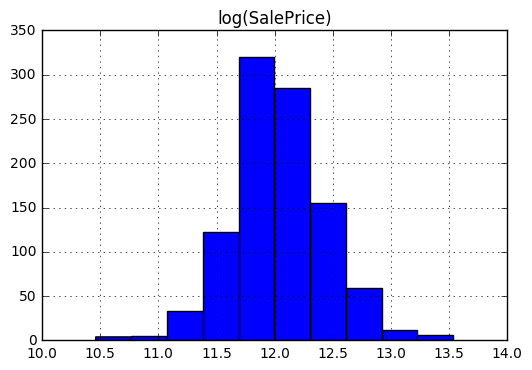

In [140]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Define ranked predictions plot function

In [141]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')


#### Function to generate submission file

In [142]:
import re
import time

def gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple prediction blending function

In [143]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### Random forest model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1497530715156_39


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.017103284870273683
RMSE: 0.13077952771849913
MAE: 0.08983148719488154
RMSLE: 0.010147981199023763
Mean Residual Deviance: 0.017103284870273683

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.018264657787037664
RMSE: 0.13514680087607572
MAE: 0.09885812331003446
RMSLE: 0.010437127656733918
Mean Residual Deviance: 0.018264657787037664

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.018240553858393096
RMSE: 0.13505759459724245
MAE: 0.08959435620967451
RMSLE: 0.010509925297604954
Mean Residual Deviance: 0.018240553858393096
Cross-Validation Metrics Summary: 


mean       sd           cv_1_valid    cv_2_valid    cv_3_valid
----------------------  ---------  -----------  ------------  ------------  ------------
mae                     0.089526   0.00112467   0.0884336     0.091775      0.0883693
mean_residual_deviance  0.0182064  0.00158918   0.0198677     0.0197224     0.0150292
mse                     0.0182064  0.00158918   0.0198677     0.0197224     0.0150292
r2                      0.881893   0.00416688   0.874172      0.888469      0.883037
residual_deviance       0.0182064  0.00158918   0.0198677     0.0197224     0.0150292
rmse                    0.134661   0.00603553   0.140953      0.140436      0.122594
rmsle                   0.0104696  0.000539345  0.0109937     0.0110241     0.00939107

Scoring History: 


timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance     validation_rmse      validation_mae       validation_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  --------------------  -------------------  -------------------  ---------------------
     2017-06-15 15:57:45  1 min 57.627 sec  0.0                nan                  nan                  nan                   nan                  nan                  nan
     2017-06-15 15:57:45  1 min 57.913 sec  1.0                0.22389434254761995  0.14509922177920787  0.050128676624830976  0.2240791840048663   0.15367623871447994  0.05021148070428672
     2017-06-15 15:57:46  1 min 58.201 sec  2.0                0.21287757434882873  0.1448768947435462   0.045316861660641104  0.17862174330971572  0.13064843844744115  0.031905727183001976
     2017-06-15 15:57:46  1 min 58.471 sec  3.0                0.20791949831379197  0.1440704305548417   0.04323051777905894   0.166280021020045    0.12094413048128508  0.02764904539042661
     2017-06-15 15:57:46  1 min 58.784 sec  4.0                0.20632578986464015  0.13960379474567916  0.042570331563267644  0.16034339916510307  0.12092251871146407  0.025710005655819577
---  ---                  ---               ---                ---                  ---                  ---                   ---                  ---                  ---
     2017-06-15 15:58:28  2 min 40.497 sec  147.0              0.1309164107936878   0.08981522709854244  0.017139106615101613  0.1351601895645455   0.09889253305635856  0.018268276843123876
     2017-06-15 15:58:28  2 min 40.806 sec  148.0              0.13078267690317938  0.08975528538855954  0.01710410857796141   0.1351861243678614   0.09889164608583247  0.01827528822160289
     2017-06-15 15:58:29  2 min 41.204 sec  149.0              0.1306617352101919   0.08971940178464238  0.0170724890481383    0.13517227632378012  0.0989531664017169   0.01827154428655237
     2017-06-15 15:58:29  2 min 41.525 sec  150.0              0.1306831594443237   0.08986705154889306  0.01707808816235053   0.13502153356393912  0.09878290307980653  0.018230814525957935
     2017-06-15 15:58:29  2 min 41.839 sec  151.0              0.13077952771849913  0.08983148719488154  0.017103284870273683  0.13514680087607572  0.09885812331003446  0.018264657787037664


See the whole table with table.as_data_frame()
Variable Importances: 


variable                           relative_importance    scaled_importance    percentage
---------------------------------  ---------------------  -------------------  --------------------
GrLivArea|Neighborhood_Tencode     1603.1712646484375     1.0                  0.07709063224409438
Neighborhood_Tencode|OverallQual   1294.7052001953125     0.8075900739645747   0.06225762939598401
LotShape_Tencode|OverallQual       1124.1563720703125     0.7012079101335632   0.054056561126756504
GrLivArea|OverallQual              958.2045288085938      0.597693178475676    0.0460765450166722
YearRemodAdd|OverallQual           816.1578369140625      0.5090896118906169   0.039246040049548285
---                                ---                    ---                  ---
MiscVal|HouseStyle_Tencode         0.0                    0.0                  0.0
MiscVal|MiscFeature_Tencode        0.0                    0.0                  0.0
Street_Tencode|PoolQC_Tencode      0.0                    0.0                  0.0
Street_Tencode|GarageQual_Tencode  0.0                    0.0                  0.0
Street_Tencode|Utilities_Tencode   0.0                    0.0                  0.0


See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 12.1712 
 12.2061 12.3031 
 11.6784 11.71 
 11.7906 11.7274 
 11.9117 11.825 
 11.9767 11.8828 
 11.8451 11.7094 
 11.1346 11.1583 
 11.914 11.7471 
 11.8845 11.8584


drf prediction progress: |████████████████████████████████████████████████| 100%


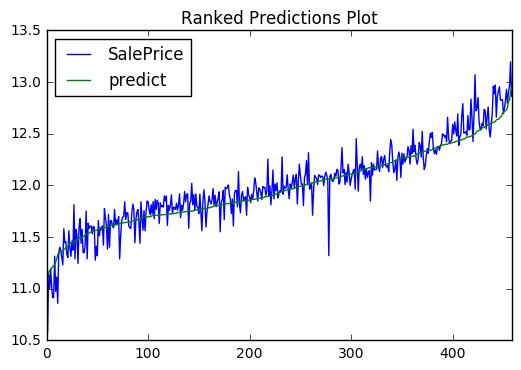

In [191]:
# initialize rf model
rf_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345)           

# train rf model
rf_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information
print(rf_model1)

rf_preds1_val = rf_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, rf_preds1_val) # valid RMSE not so hot ...
rf_preds1_test = rf_model1.predict(test)
gen_submission(rf_preds1_test) # 0.14574 public leaderboard

#### Extremely random trees model - typically not tuned as much as GBM

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1497530715156_40


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.017324102070941275
RMSE: 0.13162105481624614
MAE: 0.0892460685529443
RMSLE: 0.01021143122248222
Mean Residual Deviance: 0.017324102070941275

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.018656079782938404
RMSE: 0.1365872606905139
MAE: 0.10084357998026773
RMSLE: 0.010555786838637508
Mean Residual Deviance: 0.018656079782938404

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.018342256462386228
RMSE: 0.13543358690659502
MAE: 0.08997786478212023
RMSLE: 0.010550036662112572
Mean Residual Deviance: 0.018342256462386228
Cross-Validation Metrics Summary: 


mean       sd          cv_1_valid    cv_2_valid    cv_3_valid
----------------------  ---------  ----------  ------------  ------------  ------------
mae                     0.0898772  0.00170858  0.0886332     0.0932554     0.0877428
mean_residual_deviance  0.018287   0.00172917  0.0195059     0.0204803     0.0148747
mse                     0.018287   0.00172917  0.0195059     0.0204803     0.0148747
r2                      0.881629   0.00258281  0.876463      0.884183      0.884239
residual_deviance       0.018287   0.00172917  0.0195059     0.0204803     0.0148747
rmse                    0.134912   0.00655086  0.139664      0.14311       0.121962
rmsle                   0.0104987  0.00058388  0.0108981     0.0112494     0.00934871

Scoring History: 


timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance     validation_rmse      validation_mae       validation_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  --------------------  -------------------  -------------------  ---------------------
     2017-06-15 16:01:03  2 min 31.304 sec  0.0                nan                  nan                  nan                   nan                  nan                  nan
     2017-06-15 16:01:03  2 min 31.617 sec  1.0                0.22848495387548126  0.15096107727201113  0.052205374147480804  0.23060713377421968  0.16214398776783662  0.053179650147560854
     2017-06-15 16:01:03  2 min 31.930 sec  2.0                0.20951383420500885  0.14316414266392805  0.04389604672328394   0.174300429379578    0.12683867681000488  0.03038063968190525
     2017-06-15 16:01:04  2 min 32.227 sec  3.0                0.21786826486164945  0.1450368586757727   0.04746658083382584   0.16198949813861013  0.11869085570912302  0.026240597507198773
     2017-06-15 16:01:04  2 min 32.541 sec  4.0                0.20806161547677032  0.13957488189226153  0.043289635834803435  0.15899948864075777  0.12060554770342924  0.02528083738802246
---  ---                  ---               ---                ---                  ---                  ---                   ---                  ---                  ---
     2017-06-15 16:01:56  3 min 24.856 sec  166.0              0.13172463477175883  0.08928131901116723  0.017351379405753257  0.1366874519653667   0.10097258845148373  0.018683459524784427
     2017-06-15 16:01:57  3 min 25.177 sec  167.0              0.13164925378288403  0.08916817483636895  0.0173315260215902    0.13674678117860414  0.10100487223368598  0.018699682162709046
     2017-06-15 16:01:57  3 min 25.481 sec  168.0              0.1316442336605574   0.08917107763383465  0.01733020425607544   0.13671098966587056  0.10096994811957499  0.018689894695421767
     2017-06-15 16:01:57  3 min 25.830 sec  169.0              0.13158595413890353  0.08925151318713247  0.017314863326645627  0.136502490406494    0.10082431464760724  0.018632929887174986
     2017-06-15 16:01:58  3 min 26.258 sec  170.0              0.13162105481624614  0.0892460685529443   0.017324102070941275  0.1365872606905139   0.10084357998026773  0.018656079782938404


See the whole table with table.as_data_frame()
Variable Importances: 


variable                          relative_importance    scaled_importance    percentage
--------------------------------  ---------------------  -------------------  --------------------
GrLivArea|Neighborhood_Tencode    1777.0230712890625     1.0                  0.0758818482968711
Neighborhood_Tencode|OverallQual  1632.1829833984375     0.9184928489501506   0.06969693502579627
LotShape_Tencode|OverallQual      1124.03271484375       0.6325369281943933   0.0479980712274158
GrLivArea|OverallQual             1066.8115234375        0.6003363381566166   0.045554630939099484
BldgType_Tencode|OverallQual      883.5972290039062      0.4972345285100547   0.037731075060366194
---                               ---                    ---                  ---
MiscVal|HouseStyle_Tencode        0.0                    0.0                  0.0
MiscVal|MiscFeature_Tencode       0.0                    0.0                  0.0
MiscVal|OverallQual               0.0                    0.0                  0.0
Street_Tencode|PoolQC_Tencode     0.0                    0.0                  0.0
Street_Tencode|Heating_Tencode    0.0                    0.0                  0.0


See the whole table with table.as_data_frame()

drf prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 12.158 
 12.2061 12.3103 
 11.6784 11.701 
 11.7906 11.716 
 11.9117 11.8218 
 11.9767 11.8833 
 11.8451 11.6965 
 11.1346 11.1619 
 11.914 11.7635 
 11.8845 11.8395


drf prediction progress: |████████████████████████████████████████████████| 100%


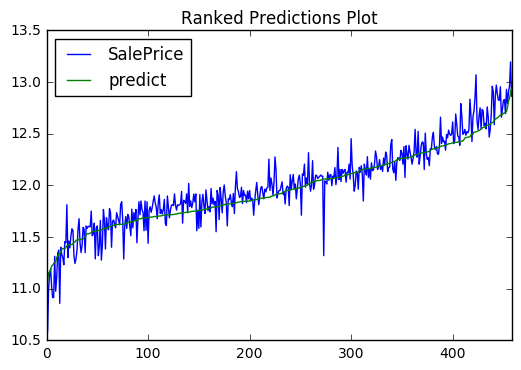

In [192]:
# initialize extra trees model
ert_model1 = H2ORandomForestEstimator(
    ntrees=10000,                    
    max_depth=10, 
    col_sample_rate_per_tree=0.1,
    sample_rate=0.8,
    stopping_rounds=50,
    score_each_iteration=True,
    nfolds=3,
    keep_cross_validation_predictions=True,
    seed=12345,
    histogram_type='random') # <- this is what makes it ERT instead of RF

# train ert model
ert_model1.train(
    x=encoded_combined_nums,
    y='SalePrice',
    training_frame=train,
    validation_frame=valid)

# print model information/create submission
print(ert_model1)
ert_preds1_val = ert_model1.predict(valid)
ranked_preds_plot('SalePrice', valid, ert_preds1_val) # valid RMSE not so hot ...
ert_preds1_test = ert_model1.predict(test)
gen_submission(ert_preds1_test) # 0.14855 public leaderboard

#### H2O GBM model

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1497530715156_41


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.006176434976609031
RMSE: 0.07859029823463601
MAE: 0.05301111489980966
RMSLE: 0.006099179628794482
Mean Residual Deviance: 0.006176434976609031

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.017546665790746808
RMSE: 0.13246382823528394
MAE: 0.10119308547315771
RMSLE: 0.010243903760409427
Mean Residual Deviance: 0.017546665790746808

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.01645365655874634
RMSE: 0.12827180734185648
MAE: 0.08578849396442542
RMSLE: 0.009938680530110027
Mean Residual Deviance: 0.01645365655874634
Cross-Validation Metrics Summary: 


mean        sd          cv_1_valid    cv_2_valid    cv_3_valid
----------------------  ----------  ----------  ------------  ------------  ------------
mae                     0.0857441   0.00111212  0.0861861     0.0874109     0.0836352
mean_residual_deviance  0.0164479   0.00186011  0.0192577     0.0171547     0.0129314
mse                     0.0164479   0.00186011  0.0192577     0.0171547     0.0129314
r2                      0.893463    0.00778445  0.878035      0.90299       0.899363
residual_deviance       0.0164479   0.00186011  0.0192577     0.0171547     0.0129314
rmse                    0.127821    0.0074029   0.138772      0.130976      0.113716
rmsle                   0.00989855  0.00060685  0.0107699     0.0101946     0.00873118

Scoring History: 


timestamp            duration           number_of_trees    training_rmse        training_mae          training_deviance     validation_rmse      validation_mae       validation_deviance
---  -------------------  -----------------  -----------------  -------------------  --------------------  --------------------  -------------------  -------------------  ---------------------
     2017-06-15 16:21:26  18 min 50.401 sec  0.0                0.39378907815806025  0.30487372622172093   0.1550698380765749    0.41138476712278926  0.3219006088183906   0.16923742662067154
     2017-06-15 16:21:26  18 min 50.629 sec  1.0                0.39250058616301964  0.3036121507505556    0.15405671013831398   0.41001060858300487  0.3205841446329741   0.168108699150606
     2017-06-15 16:21:27  18 min 50.785 sec  2.0                0.3912234134200247   0.3024207409564313    0.15305575920801556   0.4087253276963698   0.3193950229634724   0.16705639350050489
     2017-06-15 16:21:27  18 min 50.977 sec  3.0                0.3898574221706353   0.30122557934466654   0.15198880962153297   0.4072897587868043   0.3181570115561474   0.16588494761261324
     2017-06-15 16:21:27  18 min 51.163 sec  4.0                0.38834094233926464  0.29982838168606296   0.15080868749694806   0.40576787919725893  0.3168080207459082   0.16464757178824133
---  ---                  ---                ---                ---                  ---                   ---                   ---                  ---                  ---
     2017-06-15 16:27:24  24 min 48.471 sec  2423.0             0.07955753570237394  0.05369247089732777   0.006329401487034504  0.13244769803149775  0.10124479670328616  0.017542392713842815
     2017-06-15 16:27:28  24 min 52.499 sec  2452.0             0.07926858102895806  0.05349240222058215   0.00628350793834449   0.13289424681615838  0.10169850114682775  0.017660880836834023
     2017-06-15 16:27:32  24 min 56.543 sec  2480.0             0.07906694762441725  0.053353031436641975  0.006251582206642342  0.13247436606123608  0.10123993038975107  0.017549457663326377
     2017-06-15 16:27:36  25 min  0.691 sec  2510.0             0.07877270404471433  0.053199738532036814  0.006205138902516154  0.13257430777552223  0.10131743617906665  0.017575947082158892
     2017-06-15 16:27:40  25 min  4.621 sec  2537.0             0.07859029823463601  0.05301111489980966   0.006176434976609031  0.13246382823528394  0.10119308547315771  0.017546665790746808


See the whole table with table.as_data_frame()
Variable Importances: 


variable                               relative_importance    scaled_importance    percentage
-------------------------------------  ---------------------  -------------------  -------------------
Neighborhood_Tencode|OverallQual       3338.483154296875      1.0                  0.3173326261258274
GrLivArea|Neighborhood_Tencode         1284.7108154296875     0.3848187203749013   0.12211553511894786
LotShape_Tencode|OverallQual           1223.488525390625      0.36648036513705473  0.11629617669249369
GrLivArea|OverallQual                  904.2254028320312      0.270849173424232    0.08594927948672118
GrLivArea|KitchenQual_Tencode          526.5789184570312      0.15772999117257344  0.0500528723175963
---                                    ---                    ---                  ---
Utilities_Tencode|MiscFeature_Tencode  0.0                    0.0                  0.0
Utilities_Tencode|OverallQual          0.0                    0.0                  0.0
HalfBath|SaleType_Tencode              0.0                    0.0                  0.0
HalfBath|MiscFeature_Tencode           0.0                    0.0                  0.0
HalfBath|OverallQual                   0.0                    0.0                  0.0


See the whole table with table.as_data_frame()

gbm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 12.0243 
 12.2061 12.3046 
 11.6784 11.6736 
 11.7906 11.6473 
 11.9117 11.8533 
 11.9767 11.8995 
 11.8451 11.6644 
 11.1346 11.0265 
 11.914 11.7871 
 11.8845 11.8265


gbm prediction progress: |████████████████████████████████████████████████| 100%


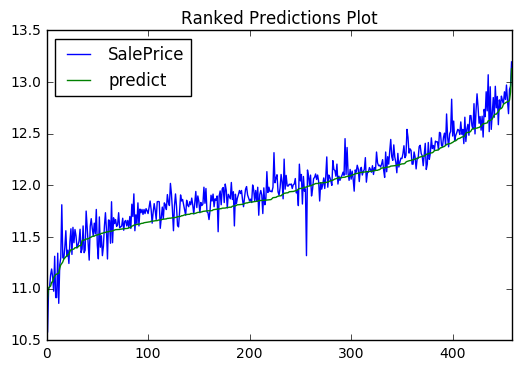

In [193]:
# initialize H2O GBM
h2o_gbm_model = H2OGradientBoostingEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training
h2o_gbm_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_gbm_model)
h2o_gbm_preds1_val = h2o_gbm_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_gbm_preds1_val) # better validation error
h2o_gbm_preds1_test = h2o_gbm_model.predict(test)
gen_submission(h2o_gbm_preds1_test) # 0.15062 public leaderboard

#### Train H2O XGBoost - very new!!

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1497530715156_42


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.00840358868692754
RMSE: 0.09167108970077502
MAE: 0.05488036133788087
RMSLE: 0.007108057792476213
Mean Residual Deviance: 0.00840358868692754

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.020605834537669652
RMSE: 0.1435473250801618
MAE: 0.11459932348047726
RMSLE: 0.011121763109013057
Mean Residual Deviance: 0.020605834537669652

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.017285036067784806
RMSE: 0.13147256773861538
MAE: 0.08792207052895834
RMSLE: 0.010168982730659084
Mean Residual Deviance: 0.017285036067784806
Cross-Validation Metrics Summary: 


mean       sd           cv_1_valid    cv_2_valid    cv_3_valid
----------------------  ---------  -----------  ------------  ------------  ------------
mae                     0.0878787  0.000750285  0.0866027     0.0892005     0.087833
mean_residual_deviance  0.017241   0.00157408   0.0185664     0.0190513     0.0141053
mse                     0.017241   0.00157408   0.0185664     0.0190513     0.0141053
r2                      0.888302   0.00300235   0.882413      0.892264      0.890227
residual_deviance       0.017241   0.00157408   0.0185664     0.0190513     0.0141053
rmse                    0.131017   0.0061468    0.136259      0.138026      0.118766
rmsle                   0.0101289  0.000516397  0.0105763     0.0107113     0.00909901

Scoring History: 


timestamp            duration          number_of_trees    training_rmse        training_mae          training_deviance     validation_rmse      validation_mae       validation_deviance
---  -------------------  ----------------  -----------------  -------------------  --------------------  --------------------  -------------------  -------------------  ---------------------
     2017-06-15 17:05:02  5 min 50.591 sec  0.0                11.53922078459229    11.532499576305652    133.1536163155667     11.512946582875738   11.505625745569699   132.54793902015015
     2017-06-15 17:05:02  5 min 51.417 sec  1.0                11.481972463980574   11.475217724537158    131.83569166360815    11.455701337489975   11.448343893801205   131.23309313376961
     2017-06-15 17:05:02  5 min 51.437 sec  2.0                11.425215032111922   11.41842671701839     130.53553852999622    11.398946985752854   11.391552886282437   129.9359923840041
     2017-06-15 17:05:02  5 min 51.458 sec  3.0                11.368889452544892   11.362067485546374    129.2516473841865     11.342624494141042   11.335193654810421   128.6551304150883
     2017-06-15 17:05:02  5 min 51.479 sec  4.0                11.312508392481122   11.305652404522204    127.97284612995584    11.286246556740403   11.278778573786251   127.3793613395346
---  ---                  ---               ---                ---                  ---                   ---                   ---                  ---                  ---
     2017-06-15 17:07:07  7 min 56.013 sec  2934.0             0.09440304636653715  0.057071795353999026  0.008911935163282564  0.1445219798103446   0.11559287343409586  0.020886602648301653
     2017-06-15 17:07:11  8 min  0.018 sec  3015.0             0.09374197694040097  0.056437849641203526  0.008787558240694668  0.1443554698747465   0.11557528551887064  0.020838501682758845
     2017-06-15 17:07:15  8 min  4.046 sec  3096.0             0.09300692652368871  0.05588111439189473   0.008650288381382829  0.1433479879404267   0.11448975689790347  0.020548645646568713
     2017-06-15 17:07:19  8 min  8.086 sec  3178.0             0.09233692702383729  0.05538754077343555   0.008526108092205454  0.14324911048599173  0.11437043748909612  0.02052030765502787
     2017-06-15 17:07:23  8 min 12.098 sec  3260.0             0.09167108970077502  0.05488036133788087   0.00840358868692754   0.1435473250801618   0.11459932348047726  0.020605834537669652


See the whole table with table.as_data_frame()
Variable Importances: 


variable                              relative_importance    scaled_importance     percentage
------------------------------------  ---------------------  --------------------  ---------------------
Neighborhood_Tencode|OverallCond      87.0                   1.0                   0.005504238896621536
MSSubClass|LotArea                    64.0                   0.735632183908046     0.004049095280273314
GrLivArea|OverallCond                 58.0                   0.6666666666666666    0.0036694925977476906
GrLivArea|MoSold                      55.0                   0.632183908045977     0.0034796912564848794
LotArea|OverallCond                   55.0                   0.632183908045977     0.0034796912564848794
---                                   ---                    ---                   ---
GarageArea|GarageCars                 1.0                    0.011494252873563218  6.326711375427053e-05
KitchenAbvGr|OpenPorchSF              1.0                    0.011494252873563218  6.326711375427053e-05
BsmtFullBath|HalfBath                 1.0                    0.011494252873563218  6.326711375427053e-05
KitchenAbvGr|2ndFlrSF                 1.0                    0.011494252873563218  6.326711375427053e-05
FireplaceQu_Tencode|RoofMatl_Tencode  1.0                    0.011494252873563218  6.326711375427053e-05


See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


SalePrice predict 
 
 
 11.8494 11.977 
 12.2061 12.2466 
 11.6784 11.6435 
 11.7906 11.5821 
 11.9117 11.8348 
 11.9767 11.8584 
 11.8451 11.6547 
 11.1346 11.1257 
 11.914 11.7848 
 11.8845 11.8398


xgboost prediction progress: |████████████████████████████████████████████| 100%


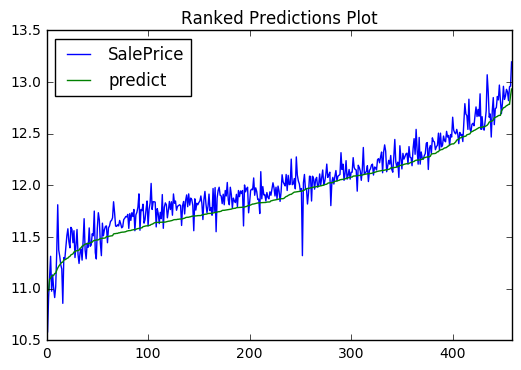

In [194]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.16494 on public leaderboard

#### Create blend

In [196]:
# create XGBoost blend
pred_blender('../data',
            ['submission_Thu_Jun_15_15_58_31_2017.csv',
             'submission_Thu_Jun_15_16_01_59_2017.csv',
             'submission_Thu_Jun_15_16_27_42_2017.csv',
             'submission_Thu_Jun_15_17_07_26_2017.csv'])
# 0.14705 on public leaderboard

     Id     SalePrice0     SalePrice1     SalePrice2     SalePrice3  \
0  1461  119081.074863  118567.449551  111874.076414  108450.225192   
1  1462  150015.290818  144812.782606  152345.926941  147465.853860   
2  1463  176503.892538  176940.325397  168826.171846  168720.909452   
3  1464  185223.022830  185907.910302  185119.575064  177289.259208   
4  1465  192687.508653  189991.207625  179623.201624  173343.132782   

            mean  
0  114493.206505  
1  148659.963557  
2  172747.824808  
3  183384.941851  
4  183911.262671  


#### Train H2O stacked ensemble

stackedensemble Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_model_python_1497530715156_43
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.0037195951897363083
RMSE: 0.06098848407475225
MAE: 0.04305787492087697
RMSLE: 0.004733690637851762
R^2: 0.9760134192704554
Mean Residual Deviance: 0.0037195951897363083
Null degrees of freedom: 1000
Residual degrees of freedom: 997
Null deviance: 155.22490791465145
Residual deviance: 3.7233147849260444
AIC: -2749.019633542589

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.016980254787969905
RMSE: 0.13030830667294355
MAE: 0.09925529488015572
RMSLE: 0.01009315309820752
R^2: 0.8992360780098589
Mean Residual Deviance: 0.016980254787969905
Null degrees of freedom: 458
Residual degrees of freedom: 455
Null deviance: 77.67997881888834
Residual

SalePrice predict 
 
 
 11.8494 12.0728 
 12.2061 12.3159 
 11.6784 11.6697 
 11.7906 11.6571 
 11.9117 11.8351 
 11.9767 11.8878 
 11.8451 11.6624 
 11.1346 11.0312 
 11.914 11.7651 
 11.8845 11.8257


stackedensemble prediction progress: |████████████████████████████████████| 100%


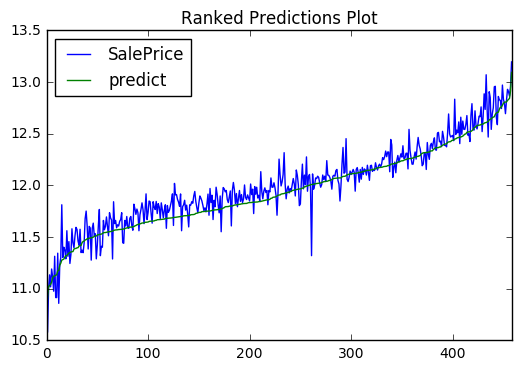

In [195]:
stack = H2OStackedEnsembleEstimator(training_frame=train, 
                                    validation_frame=valid, 
                                    base_models=[rf_model1, ert_model1, 
                                                 h2o_gbm_model])

stack.train(x=encoded_combined_nums,
            y='SalePrice',
            training_frame=train,
            validation_frame=valid)

# print model information/create submission
print(stack)
stack_preds1_val = stack.predict(valid)
ranked_preds_plot('SalePrice', valid, stack_preds1_val) 
stack_preds1_test = stack.predict(test)
gen_submission(stack_preds1_test)
# 0.14630 on public leaderboard

#### Native XGBoost GBM model (for example)

[0]	train-rmse:0.394481	eval-rmse:0.386675
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.392907	eval-rmse:0.385508
[2]	train-rmse:0.391742	eval-rmse:0.384175
[3]	train-rmse:0.390294	eval-rmse:0.382704
[4]	train-rmse:0.388924	eval-rmse:0.381541
[5]	train-rmse:0.387633	eval-rmse:0.380214
[6]	train-rmse:0.386467	eval-rmse:0.379089
[7]	train-rmse:0.385057	eval-rmse:0.377412
[8]	train-rmse:0.383782	eval-rmse:0.376077
[9]	train-rmse:0.382354	eval-rmse:0.374844
[10]	train-rmse:0.381072	eval-rmse:0.373659
[11]	train-rmse:0.379447	eval-rmse:0.372006
[12]	train-rmse:0.377973	eval-rmse:0.370835
[13]	train-rmse:0.376468	eval-rmse:0.369565
[14]	train-rmse:0.374766	eval-rmse:0.368023
[15]	train-rmse:0.373482	eval-rmse:0.366748
[16]	train-rmse:0.372088	eval-rmse:0.365415
[17]	train-rmse:0.370921	eval-rmse:0.364812
[18]	train-rmse:0.369993	eval-rmse:0.364129
[19]	train-rmse:0.36835	eval-rm

SalePrice predict 
 
 
 11.8494 12.062 
 12.2061 12.306 
 11.6784 11.6806 
 11.914 11.7686 
 12.6758 12.487 
 12.861 12.5802 
 12.1035 11.9194 
 11.2898 11.4222 
 11.7714 11.6392 
 11.5843 11.6461


Parse progress: |█████████████████████████████████████████████████████████| 100%


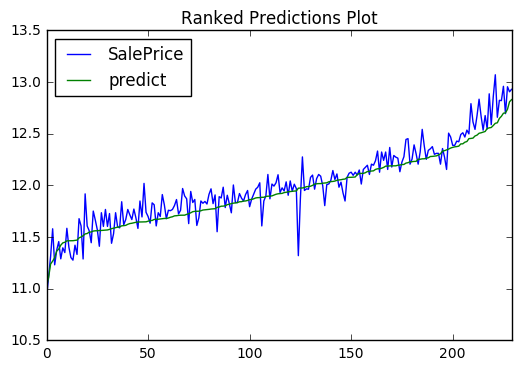

In [107]:
"""

ave_y = half_train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain1 = xgb.DMatrix(train.as_data_frame()[encoded_combined_nums],
                      train.as_data_frame()['SalePrice'])
dvalid1 = xgb.DMatrix(valid.as_data_frame()[encoded_combined_nums],
                      valid.as_data_frame()['SalePrice'])
dtest = xgb.DMatrix(test.as_data_frame()[encoded_combined_nums])

# tuning parameters
params1 = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.007,
    'reg_lambda' : 0.0,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain1, 'train'), (dvalid1, 'eval')]

# train model
xgb_model1 = xgb.train(params1, 
                       dtrain1, 
                       10000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)

# create assessment stats and submission file
xgb_preds1_val = h2o.H2OFrame(xgb_model1.predict(dvalid1).tolist())
ranked_preds_plot('SalePrice', valid, xgb_preds1_val) 
xgb_preds1_test = h2o.H2OFrame(xgb_model1.predict(dtest).tolist())
gen_submission(xgb_preds1_test) 

"""

#### Shutdown H2O

In [3]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
